# Importing Libraries

In [1]:
from pathlib import Path
from tqdm.auto import tqdm
from IPython.display import clear_output

import keras
import visualkeras
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.callbacks import Callback

import matplotlib.pyplot as plt

from numpy import ones, zeros, expand_dims, vstack
from numpy.random import rand, randn, randint

In [2]:
cwd = Path.cwd()
cwd

PosixPath('/Users/hamzz/Development/~professional/researchGAN/junk')

# Loading Data

In [3]:
CLASS_NAMES = ['zero', 'one', 'two', 'three', 'four', 
               'five', 'six', 'seven', 'eight', 'nine',]
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print("Training--> X: {} y: {}".format(X_train.shape, y_train.shape))
print("Testing---> X: {} y: {}".format(X_test.shape, y_test.shape))

Training--> X: (60000, 28, 28) y: (60000,)
Testing---> X: (10000, 28, 28) y: (10000,)


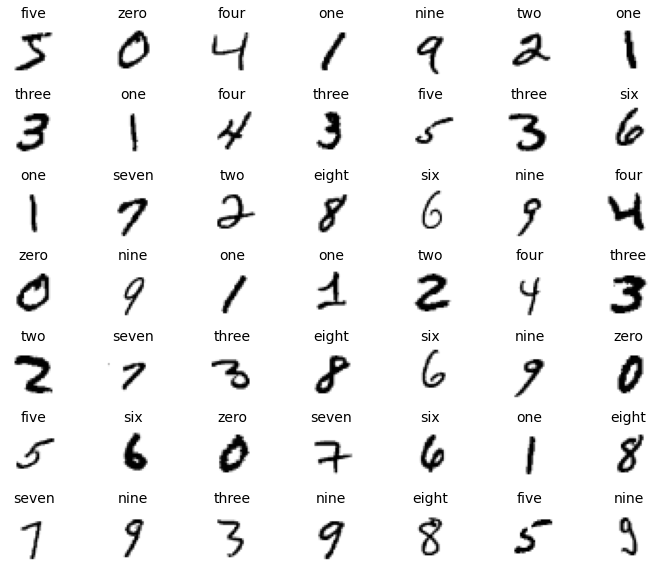

In [4]:
def plot_data(data=None,
              n=5,
              figsize=(10, 8), 
              save=False, 
              name=None, path='/plot_data/',
              axis='on', show=False):

    images, labels = data
    
    plt.figure(figsize=(figsize))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis(axis)
        plt.imshow(images[i], cmap='gray_r')
        if labels is not None:
            plt.title(CLASS_NAMES[labels[i]], fontsize=14)
    plt.tight_layout()
    if save:
        while name is None:
            name = input("Enter name for figure: ")

        file_path = cwd / Path('figures') / Path(path)
        file_path.mkdir(parents=True, exist_ok=True)
        plt.savefig(file_path.joinpath(str(name) + '.png'))
    if show:
        plt.show()
    plt.close()

plot_data(data=(X_train, y_train), n=7,
          save=True, 
          name='loading_data', axis='off', path='visualisation', show=True)

# Discriminator Model

Discriminator


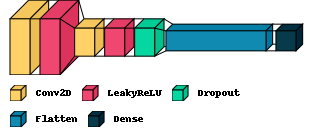

In [37]:
def define_discriminator(in_shape=(28, 28, 1)):
    model = keras.models.Sequential([

        # DOWNSAMPLE 14X14
        keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape=in_shape),
        keras.layers.LeakyReLU(0.2),

        # DOWNSAMPLE 7x7
        keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same'),
        keras.layers.LeakyReLU(0.2),
        keras.layers.Dropout(0.4),

        # CLASSIFIER
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation='sigmoid'),
    ], name='discriminator')

    opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

model = define_discriminator()
print(model.name.title())
visualkeras.layered_view(model, 
                         to_file='DC-GAN-discriminator.png',max_z=100,
                         legend=True)

In [6]:
model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 1)               

# Generator Model

Generator


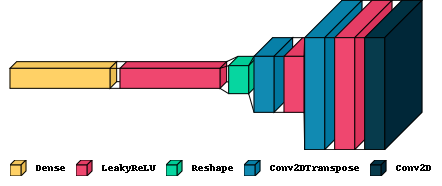

In [34]:
def define_generator(latent_dim):
    n_nodes = 128 * 7 * 7
    model = keras.models.Sequential([
        keras.layers.Dense(n_nodes, input_dim=latent_dim),
        keras.layers.LeakyReLU(0.2),
        keras.layers.Reshape((7, 7, 128)),

        # UPSAMPLE 14X14
        keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), 
                                     strides=(2, 2), padding='same'),
        keras.layers.LeakyReLU(0.2),

        # UPSAMPLE 28X28
        keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), 
                                     strides=(2, 2), padding='same'),
        keras.layers.LeakyReLU(0.2),

        keras.layers.Conv2D(1, kernel_size=(7, 7), activation='tanh', 
                            padding='same')        
    ], name='generator')    
    
    return model

model = define_generator(latent_dim=100)
print(model.name.title())
visualkeras.layered_view(model, 
                         to_file='DC-GAN-generator.png',max_z=100,
                         legend=True)

# GAN model

Gan


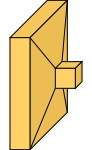

In [8]:
def define_gan(g_model, d_model):
    d_model.trainable = False

    model = keras.models.Sequential([
        g_model, 
        d_model
    ], name='gan')

    opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(loss='binary_crossentropy',
                optimizer=opt)

    return model

model = define_gan(g_model=define_generator(latent_dim=100),
                  d_model=define_discriminator())
print(model.name.title())
visualkeras.layered_view(model, legend=False)

# Preprocessing and Preparing Training Images

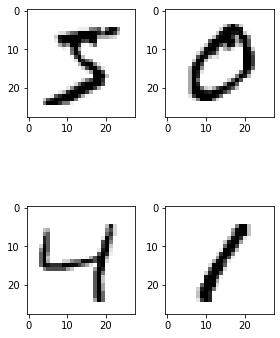

(0.5, -0.5)

In [22]:
def load_real_samples(dataset=keras.datasets.mnist):
    (X_train, _), (_, _) = dataset.load_data()

    # EXPAND IT TO 3D
    X = expand_dims(X_train, axis=-1)

    # NORMALISE THE DATA
    X = X.astype('float32') 
    X = (X - 127.5) / 255.0

    return X

In [10]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)

    X = dataset[ix]
    y = ones((n_samples, 1))

    return (X, y)

In [11]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [12]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return (X, y)

# Model Summarising

In [13]:
def save_plot(X, epoch, n=7):
    X = (X + 1) / 2.0
    
    plot_data(data=(X, None),
              n=n, save=True, name=f'gen_plot_e-{epoch+1}',
              path=f'{GAN_NAME}/{DATASET_NAME}/generated', axis='off')

In [14]:
def save_model(g_model, epoch, path=None):
    file_path = cwd / Path('models') / Path(path)
    file_path.mkdir(parents=True, exist_ok=True)
    
    g_model.save(file_path / f'gen_model_e-{epoch+1}.h5')

In [15]:
def summarise_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    (X_real, y_real) = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    (X_fake, y_fake) = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)

    print(">Real: {:.4f}% | Fake: {:.4f}".format(acc_real*100,
                                                acc_fake*100))

    save_model(g_model, epoch, path=f'{GAN_NAME}')
    save_plot(X_fake, epoch)

# Model Training

In [18]:
def train(g_model, d_model, gan_model, dataset, latent_dim, epochs=100, batch_size=256):
    batch_per_epoch = dataset.shape[0] // batch_size
    half_batch = batch_size // 2

    for i in tqdm(range(epochs), desc="Epochs"):
        for j in tqdm(range(batch_per_epoch), desc="Batches"):
            
            # GET RANDOMLY SELECTED REAL SAMPLES
            (X_real, y_real) = generate_real_samples(dataset, half_batch)
            # UPDATE THE DISCRIMINATOR MODEL WEIGHTS
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)

            # GENERATE FAKE SAMPLES
            (X_fake, y_fake) = generate_fake_samples(g_model, latent_dim, half_batch)
            # UPDATE THE DISCRIMINATOR MODEL WEIGHTS
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

            # PREPARE POINTS IN LATENT SPACE AS INPUT FOR THE GENERATOR
            X_gan = generate_latent_points(latent_dim, batch_size)
            # INVERTED LABELS FOR THE FAKE SAMPLES (FOOLING THE DISCRIMINATOR)
            y_gan = ones((batch_size, 1))            
            # TRAINING THE GENERATOR
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            print(">{:3} | ({:3}/{:3}) | D1:{:.3f} | D2:{:.3f} | G: {:.3f}".format(i+1, j+1, batch_per_epoch,            
                                                                                   d_loss1, d_loss2, g_loss))
        
        summarise_performance(i, g_model, d_model, dataset, latent_dim, n_samples=100)
            
    g_model.save('generator.h5')

In [ ]:
dataset = tf.keras.datasets.mnist
DATASET_NAME = 'mnist'
GAN_NAME = 'DC-GAN'

latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

dataset = load_real_samples(dataset=dataset)

train(g_model, d_model, gan_model, dataset, latent_dim)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 14ms/step
>  1 | (  1/234) | D1:0.692 | D2:0.694 | G: 0.693
4/4 [==============================] - 0s 12ms/step
>  1 | (  2/234) | D1:0.649 | D2:0.697 | G: 0.690
4/4 [==============================] - 0s 12ms/step
>  1 | (  3/234) | D1:0.616 | D2:0.705 | G: 0.682
4/4 [==============================] - 0s 13ms/step
>  1 | (  4/234) | D1:0.589 | D2:0.720 | G: 0.667
4/4 [==============================] - 0s 12ms/step
>  1 | (  5/234) | D1:0.563 | D2:0.743 | G: 0.647
4/4 [==============================] - 0s 12ms/step
>  1 | (  6/234) | D1:0.538 | D2:0.775 | G: 0.622
4/4 [==============================] - 0s 12ms/step
>  1 | (  7/234) | D1:0.520 | D2:0.815 | G: 0.595
4/4 [==============================] - 0s 12ms/step
>  1 | (  8/234) | D1:0.510 | D2:0.858 | G: 0.571
4/4 [==============================] - 0s 12ms/step
>  1 | (  9/234) | D1:0.505 | D2:0.889 | G: 0.559
4/4 [==============================] - 0s 12ms/step
>  1 | ( 10/234) | D1:0.507 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 16ms/step
>  2 | (  1/234) | D1:0.776 | D2:0.640 | G: 0.788
4/4 [==============================] - 0s 12ms/step
>  2 | (  2/234) | D1:0.777 | D2:0.640 | G: 0.782
4/4 [==============================] - 0s 12ms/step
>  2 | (  3/234) | D1:0.763 | D2:0.642 | G: 0.782
4/4 [==============================] - 0s 12ms/step
>  2 | (  4/234) | D1:0.761 | D2:0.641 | G: 0.781
4/4 [==============================] - 0s 12ms/step
>  2 | (  5/234) | D1:0.766 | D2:0.644 | G: 0.777
4/4 [==============================] - 0s 12ms/step
>  2 | (  6/234) | D1:0.770 | D2:0.647 | G: 0.780
4/4 [==============================] - 0s 12ms/step
>  2 | (  7/234) | D1:0.768 | D2:0.647 | G: 0.772
4/4 [==============================] - 0s 12ms/step
>  2 | (  8/234) | D1:0.771 | D2:0.649 | G: 0.771
4/4 [==============================] - 0s 12ms/step
>  2 | (  9/234) | D1:0.766 | D2:0.652 | G: 0.775
4/4 [==============================] - 0s 13ms/step
>  2 | ( 10/234) | D1:0.756 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 15ms/step
>  3 | (  1/234) | D1:0.732 | D2:0.674 | G: 0.732
4/4 [==============================] - 0s 12ms/step
>  3 | (  2/234) | D1:0.725 | D2:0.677 | G: 0.731
4/4 [==============================] - 0s 12ms/step
>  3 | (  3/234) | D1:0.725 | D2:0.675 | G: 0.731
4/4 [==============================] - 0s 12ms/step
>  3 | (  4/234) | D1:0.724 | D2:0.672 | G: 0.728
4/4 [==============================] - 0s 12ms/step
>  3 | (  5/234) | D1:0.720 | D2:0.676 | G: 0.729
4/4 [==============================] - 0s 12ms/step
>  3 | (  6/234) | D1:0.724 | D2:0.675 | G: 0.731
4/4 [==============================] - 0s 12ms/step
>  3 | (  7/234) | D1:0.728 | D2:0.674 | G: 0.731
4/4 [==============================] - 0s 12ms/step
>  3 | (  8/234) | D1:0.724 | D2:0.678 | G: 0.731
4/4 [==============================] - 0s 12ms/step
>  3 | (  9/234) | D1:0.723 | D2:0.676 | G: 0.731
4/4 [==============================] - 0s 12ms/step
>  3 | ( 10/234) | D1:0.723 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 15ms/step
>  4 | (  1/234) | D1:0.704 | D2:0.684 | G: 0.720
4/4 [==============================] - 0s 12ms/step
>  4 | (  2/234) | D1:0.698 | D2:0.688 | G: 0.721
4/4 [==============================] - 0s 12ms/step
>  4 | (  3/234) | D1:0.704 | D2:0.682 | G: 0.721
4/4 [==============================] - 0s 12ms/step
>  4 | (  4/234) | D1:0.700 | D2:0.683 | G: 0.717
4/4 [==============================] - 0s 12ms/step
>  4 | (  5/234) | D1:0.699 | D2:0.685 | G: 0.720
4/4 [==============================] - 0s 12ms/step
>  4 | (  6/234) | D1:0.698 | D2:0.685 | G: 0.718
4/4 [==============================] - 0s 12ms/step
>  4 | (  7/234) | D1:0.701 | D2:0.685 | G: 0.717
4/4 [==============================] - 0s 12ms/step
>  4 | (  8/234) | D1:0.701 | D2:0.687 | G: 0.719
4/4 [==============================] - 0s 12ms/step
>  4 | (  9/234) | D1:0.697 | D2:0.687 | G: 0.718
4/4 [==============================] - 0s 12ms/step
>  4 | ( 10/234) | D1:0.706 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 16ms/step
>  5 | (  1/234) | D1:0.684 | D2:0.691 | G: 0.715
4/4 [==============================] - 0s 12ms/step
>  5 | (  2/234) | D1:0.686 | D2:0.691 | G: 0.718
4/4 [==============================] - 0s 12ms/step
>  5 | (  3/234) | D1:0.686 | D2:0.688 | G: 0.716
4/4 [==============================] - 0s 12ms/step
>  5 | (  4/234) | D1:0.686 | D2:0.683 | G: 0.718
4/4 [==============================] - 0s 12ms/step
>  5 | (  5/234) | D1:0.687 | D2:0.689 | G: 0.718
4/4 [==============================] - 0s 12ms/step
>  5 | (  6/234) | D1:0.684 | D2:0.684 | G: 0.718
4/4 [==============================] - 0s 12ms/step
>  5 | (  7/234) | D1:0.687 | D2:0.688 | G: 0.714
4/4 [==============================] - 0s 12ms/step
>  5 | (  8/234) | D1:0.683 | D2:0.689 | G: 0.716
4/4 [==============================] - 0s 12ms/step
>  5 | (  9/234) | D1:0.685 | D2:0.686 | G: 0.722
4/4 [==============================] - 0s 12ms/step
>  5 | ( 10/234) | D1:0.689 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 16ms/step
>  6 | (  1/234) | D1:0.688 | D2:0.681 | G: 0.721
4/4 [==============================] - 0s 13ms/step
>  6 | (  2/234) | D1:0.686 | D2:0.686 | G: 0.725
4/4 [==============================] - 0s 12ms/step
>  6 | (  3/234) | D1:0.688 | D2:0.680 | G: 0.728
4/4 [==============================] - 0s 16ms/step
>  6 | (  4/234) | D1:0.689 | D2:0.680 | G: 0.724
4/4 [==============================] - 0s 12ms/step
>  6 | (  5/234) | D1:0.686 | D2:0.687 | G: 0.724
4/4 [==============================] - 0s 12ms/step
>  6 | (  6/234) | D1:0.690 | D2:0.682 | G: 0.726
4/4 [==============================] - 0s 12ms/step
>  6 | (  7/234) | D1:0.686 | D2:0.684 | G: 0.721
4/4 [==============================] - 0s 12ms/step
>  6 | (  8/234) | D1:0.683 | D2:0.684 | G: 0.723
4/4 [==============================] - 0s 12ms/step
>  6 | (  9/234) | D1:0.688 | D2:0.680 | G: 0.722
4/4 [==============================] - 0s 12ms/step
>  6 | ( 10/234) | D1:0.688 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 16ms/step
>  7 | (  1/234) | D1:0.688 | D2:0.680 | G: 0.730
4/4 [==============================] - 0s 13ms/step
>  7 | (  2/234) | D1:0.693 | D2:0.682 | G: 0.723
4/4 [==============================] - 0s 12ms/step
>  7 | (  3/234) | D1:0.684 | D2:0.683 | G: 0.721
4/4 [==============================] - 0s 12ms/step
>  7 | (  4/234) | D1:0.682 | D2:0.682 | G: 0.724
4/4 [==============================] - 0s 12ms/step
>  7 | (  5/234) | D1:0.683 | D2:0.676 | G: 0.734
4/4 [==============================] - 0s 12ms/step
>  7 | (  6/234) | D1:0.691 | D2:0.676 | G: 0.729
4/4 [==============================] - 0s 12ms/step
>  7 | (  7/234) | D1:0.685 | D2:0.683 | G: 0.733
4/4 [==============================] - 0s 12ms/step
>  7 | (  8/234) | D1:0.691 | D2:0.674 | G: 0.728
4/4 [==============================] - 0s 12ms/step
>  7 | (  9/234) | D1:0.687 | D2:0.688 | G: 0.726
4/4 [==============================] - 0s 12ms/step
>  7 | ( 10/234) | D1:0.691 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 16ms/step
>  8 | (  1/234) | D1:0.678 | D2:0.676 | G: 0.739
4/4 [==============================] - 0s 16ms/step
>  8 | (  2/234) | D1:0.684 | D2:0.666 | G: 0.743
4/4 [==============================] - 0s 12ms/step
>  8 | (  3/234) | D1:0.678 | D2:0.691 | G: 0.720
4/4 [==============================] - 0s 12ms/step
>  8 | (  4/234) | D1:0.681 | D2:0.682 | G: 0.736
4/4 [==============================] - 0s 12ms/step
>  8 | (  5/234) | D1:0.683 | D2:0.676 | G: 0.740
4/4 [==============================] - 0s 12ms/step
>  8 | (  6/234) | D1:0.684 | D2:0.692 | G: 0.721
4/4 [==============================] - 0s 12ms/step
>  8 | (  7/234) | D1:0.681 | D2:0.684 | G: 0.739
4/4 [==============================] - 0s 12ms/step
>  8 | (  8/234) | D1:0.686 | D2:0.679 | G: 0.731
4/4 [==============================] - 0s 12ms/step
>  8 | (  9/234) | D1:0.687 | D2:0.689 | G: 0.722
4/4 [==============================] - 0s 12ms/step
>  8 | ( 10/234) | D1:0.686 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 16ms/step
>  9 | (  1/234) | D1:0.678 | D2:0.693 | G: 0.714
4/4 [==============================] - 0s 12ms/step
>  9 | (  2/234) | D1:0.678 | D2:0.698 | G: 0.712
4/4 [==============================] - 0s 12ms/step
>  9 | (  3/234) | D1:0.686 | D2:0.699 | G: 0.711
4/4 [==============================] - 0s 12ms/step
>  9 | (  4/234) | D1:0.682 | D2:0.692 | G: 0.713
4/4 [==============================] - 0s 12ms/step
>  9 | (  5/234) | D1:0.677 | D2:0.696 | G: 0.718
4/4 [==============================] - 0s 12ms/step
>  9 | (  6/234) | D1:0.687 | D2:0.695 | G: 0.715
4/4 [==============================] - 0s 12ms/step
>  9 | (  7/234) | D1:0.682 | D2:0.692 | G: 0.716
4/4 [==============================] - 0s 12ms/step
>  9 | (  8/234) | D1:0.689 | D2:0.692 | G: 0.718
4/4 [==============================] - 0s 12ms/step
>  9 | (  9/234) | D1:0.681 | D2:0.692 | G: 0.716
4/4 [==============================] - 0s 12ms/step
>  9 | ( 10/234) | D1:0.686 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 19ms/step
> 10 | (  1/234) | D1:0.679 | D2:0.693 | G: 0.718
4/4 [==============================] - 0s 13ms/step
> 10 | (  2/234) | D1:0.690 | D2:0.692 | G: 0.719
4/4 [==============================] - 0s 20ms/step
> 10 | (  3/234) | D1:0.695 | D2:0.684 | G: 0.719
4/4 [==============================] - 0s 15ms/step
> 10 | (  4/234) | D1:0.676 | D2:0.691 | G: 0.725
4/4 [==============================] - 0s 31ms/step
> 10 | (  5/234) | D1:0.691 | D2:0.685 | G: 0.723
4/4 [==============================] - 0s 20ms/step
> 10 | (  6/234) | D1:0.688 | D2:0.693 | G: 0.715
4/4 [==============================] - 0s 13ms/step
> 10 | (  7/234) | D1:0.681 | D2:0.695 | G: 0.714
4/4 [==============================] - 0s 18ms/step
> 10 | (  8/234) | D1:0.690 | D2:0.694 | G: 0.713
4/4 [==============================] - 0s 21ms/step
> 10 | (  9/234) | D1:0.687 | D2:0.684 | G: 0.718
4/4 [==============================] - 0s 17ms/step
> 10 | ( 10/234) | D1:0.693 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 14ms/step
> 11 | (  1/234) | D1:0.686 | D2:0.687 | G: 0.714
4/4 [==============================] - 0s 25ms/step
> 11 | (  2/234) | D1:0.682 | D2:0.688 | G: 0.721
4/4 [==============================] - 0s 18ms/step
> 11 | (  3/234) | D1:0.686 | D2:0.687 | G: 0.718
4/4 [==============================] - 0s 14ms/step
> 11 | (  4/234) | D1:0.683 | D2:0.687 | G: 0.717
4/4 [==============================] - 0s 21ms/step
> 11 | (  5/234) | D1:0.685 | D2:0.694 | G: 0.717
4/4 [==============================] - 0s 17ms/step
> 11 | (  6/234) | D1:0.685 | D2:0.694 | G: 0.714
4/4 [==============================] - 0s 25ms/step
> 11 | (  7/234) | D1:0.685 | D2:0.689 | G: 0.717
4/4 [==============================] - 0s 24ms/step
> 11 | (  8/234) | D1:0.690 | D2:0.687 | G: 0.718
4/4 [==============================] - 0s 19ms/step
> 11 | (  9/234) | D1:0.683 | D2:0.694 | G: 0.721
4/4 [==============================] - 0s 14ms/step
> 11 | ( 10/234) | D1:0.691 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 27ms/step
> 12 | (  1/234) | D1:0.690 | D2:0.688 | G: 0.719
4/4 [==============================] - 0s 17ms/step
> 12 | (  2/234) | D1:0.684 | D2:0.692 | G: 0.716
4/4 [==============================] - 0s 17ms/step
> 12 | (  3/234) | D1:0.690 | D2:0.691 | G: 0.711
4/4 [==============================] - 0s 14ms/step
> 12 | (  4/234) | D1:0.686 | D2:0.695 | G: 0.714
4/4 [==============================] - 0s 20ms/step
> 12 | (  5/234) | D1:0.689 | D2:0.692 | G: 0.719
4/4 [==============================] - 0s 14ms/step
> 12 | (  6/234) | D1:0.689 | D2:0.688 | G: 0.721
4/4 [==============================] - 0s 26ms/step
> 12 | (  7/234) | D1:0.694 | D2:0.678 | G: 0.722
4/4 [==============================] - 0s 14ms/step
> 12 | (  8/234) | D1:0.689 | D2:0.694 | G: 0.716
4/4 [==============================] - 0s 21ms/step
> 12 | (  9/234) | D1:0.682 | D2:0.691 | G: 0.716
4/4 [==============================] - 0s 23ms/step
> 12 | ( 10/234) | D1:0.684 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 13ms/step
> 13 | (  1/234) | D1:0.684 | D2:0.688 | G: 0.721
4/4 [==============================] - 0s 18ms/step
> 13 | (  2/234) | D1:0.690 | D2:0.692 | G: 0.717
4/4 [==============================] - 0s 14ms/step
> 13 | (  3/234) | D1:0.689 | D2:0.691 | G: 0.719
4/4 [==============================] - 0s 21ms/step
> 13 | (  4/234) | D1:0.691 | D2:0.692 | G: 0.721
4/4 [==============================] - 0s 25ms/step
> 13 | (  5/234) | D1:0.690 | D2:0.687 | G: 0.711
4/4 [==============================] - 0s 25ms/step
> 13 | (  6/234) | D1:0.687 | D2:0.688 | G: 0.714
4/4 [==============================] - 0s 18ms/step
> 13 | (  7/234) | D1:0.688 | D2:0.686 | G: 0.719
4/4 [==============================] - 0s 18ms/step
> 13 | (  8/234) | D1:0.685 | D2:0.684 | G: 0.727
4/4 [==============================] - 0s 14ms/step
> 13 | (  9/234) | D1:0.687 | D2:0.691 | G: 0.715
4/4 [==============================] - 0s 18ms/step
> 13 | ( 10/234) | D1:0.685 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 15ms/step
> 14 | (  1/234) | D1:0.684 | D2:0.695 | G: 0.714
4/4 [==============================] - 0s 21ms/step
> 14 | (  2/234) | D1:0.684 | D2:0.689 | G: 0.715
4/4 [==============================] - 0s 13ms/step
> 14 | (  3/234) | D1:0.685 | D2:0.689 | G: 0.719
4/4 [==============================] - 0s 13ms/step
> 14 | (  4/234) | D1:0.687 | D2:0.685 | G: 0.717
4/4 [==============================] - 0s 19ms/step
> 14 | (  5/234) | D1:0.686 | D2:0.691 | G: 0.717
4/4 [==============================] - 0s 12ms/step
> 14 | (  6/234) | D1:0.685 | D2:0.697 | G: 0.715
4/4 [==============================] - 0s 13ms/step
> 14 | (  7/234) | D1:0.691 | D2:0.694 | G: 0.714
4/4 [==============================] - 0s 12ms/step
> 14 | (  8/234) | D1:0.676 | D2:0.686 | G: 0.721
4/4 [==============================] - 0s 13ms/step
> 14 | (  9/234) | D1:0.683 | D2:0.696 | G: 0.716
4/4 [==============================] - 0s 12ms/step
> 14 | ( 10/234) | D1:0.688 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 15ms/step
> 15 | (  1/234) | D1:0.685 | D2:0.688 | G: 0.723
4/4 [==============================] - 0s 12ms/step
> 15 | (  2/234) | D1:0.692 | D2:0.695 | G: 0.712
4/4 [==============================] - 0s 12ms/step
> 15 | (  3/234) | D1:0.687 | D2:0.689 | G: 0.715
4/4 [==============================] - 0s 12ms/step
> 15 | (  4/234) | D1:0.688 | D2:0.683 | G: 0.721
4/4 [==============================] - 0s 12ms/step
> 15 | (  5/234) | D1:0.692 | D2:0.688 | G: 0.716
4/4 [==============================] - 0s 12ms/step
> 15 | (  6/234) | D1:0.685 | D2:0.688 | G: 0.720
4/4 [==============================] - 0s 12ms/step
> 15 | (  7/234) | D1:0.688 | D2:0.691 | G: 0.719
4/4 [==============================] - 0s 12ms/step
> 15 | (  8/234) | D1:0.692 | D2:0.689 | G: 0.717
4/4 [==============================] - 0s 12ms/step
> 15 | (  9/234) | D1:0.681 | D2:0.688 | G: 0.719
4/4 [==============================] - 0s 12ms/step
> 15 | ( 10/234) | D1:0.685 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 18ms/step
> 16 | (  1/234) | D1:0.682 | D2:0.695 | G: 0.712
4/4 [==============================] - 0s 12ms/step
> 16 | (  2/234) | D1:0.692 | D2:0.696 | G: 0.714
4/4 [==============================] - 0s 13ms/step
> 16 | (  3/234) | D1:0.688 | D2:0.698 | G: 0.718
4/4 [==============================] - 0s 13ms/step
> 16 | (  4/234) | D1:0.692 | D2:0.682 | G: 0.721
4/4 [==============================] - 0s 12ms/step
> 16 | (  5/234) | D1:0.688 | D2:0.695 | G: 0.712
4/4 [==============================] - 0s 12ms/step
> 16 | (  6/234) | D1:0.683 | D2:0.689 | G: 0.725
4/4 [==============================] - 0s 12ms/step
> 16 | (  7/234) | D1:0.690 | D2:0.686 | G: 0.719
4/4 [==============================] - 0s 12ms/step
> 16 | (  8/234) | D1:0.683 | D2:0.698 | G: 0.714
4/4 [==============================] - 0s 12ms/step
> 16 | (  9/234) | D1:0.686 | D2:0.699 | G: 0.711
4/4 [==============================] - 0s 12ms/step
> 16 | ( 10/234) | D1:0.688 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 16ms/step
> 17 | (  1/234) | D1:0.687 | D2:0.695 | G: 0.714
4/4 [==============================] - 0s 12ms/step
> 17 | (  2/234) | D1:0.686 | D2:0.683 | G: 0.719
4/4 [==============================] - 0s 12ms/step
> 17 | (  3/234) | D1:0.695 | D2:0.697 | G: 0.706
4/4 [==============================] - 0s 12ms/step
> 17 | (  4/234) | D1:0.687 | D2:0.702 | G: 0.707
4/4 [==============================] - 0s 12ms/step
> 17 | (  5/234) | D1:0.682 | D2:0.698 | G: 0.716
4/4 [==============================] - 0s 12ms/step
> 17 | (  6/234) | D1:0.686 | D2:0.684 | G: 0.721
4/4 [==============================] - 0s 12ms/step
> 17 | (  7/234) | D1:0.690 | D2:0.698 | G: 0.704
4/4 [==============================] - 0s 12ms/step
> 17 | (  8/234) | D1:0.679 | D2:0.701 | G: 0.707
4/4 [==============================] - 0s 12ms/step
> 17 | (  9/234) | D1:0.682 | D2:0.696 | G: 0.718
4/4 [==============================] - 0s 12ms/step
> 17 | ( 10/234) | D1:0.690 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 16ms/step
> 18 | (  1/234) | D1:0.688 | D2:0.692 | G: 0.712
4/4 [==============================] - 0s 12ms/step
> 18 | (  2/234) | D1:0.688 | D2:0.690 | G: 0.719
4/4 [==============================] - 0s 13ms/step
> 18 | (  3/234) | D1:0.680 | D2:0.688 | G: 0.721
4/4 [==============================] - 0s 13ms/step
> 18 | (  4/234) | D1:0.692 | D2:0.699 | G: 0.710
4/4 [==============================] - 0s 12ms/step
> 18 | (  5/234) | D1:0.683 | D2:0.700 | G: 0.710
4/4 [==============================] - 0s 13ms/step
> 18 | (  6/234) | D1:0.681 | D2:0.694 | G: 0.715
4/4 [==============================] - 0s 12ms/step
> 18 | (  7/234) | D1:0.692 | D2:0.699 | G: 0.713
4/4 [==============================] - 0s 12ms/step
> 18 | (  8/234) | D1:0.686 | D2:0.690 | G: 0.716
4/4 [==============================] - 0s 13ms/step
> 18 | (  9/234) | D1:0.687 | D2:0.695 | G: 0.709
4/4 [==============================] - 0s 12ms/step
> 18 | ( 10/234) | D1:0.689 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 15ms/step
> 19 | (  1/234) | D1:0.683 | D2:0.690 | G: 0.712
4/4 [==============================] - 0s 12ms/step
> 19 | (  2/234) | D1:0.686 | D2:0.693 | G: 0.714
4/4 [==============================] - 0s 12ms/step
> 19 | (  3/234) | D1:0.684 | D2:0.686 | G: 0.717
4/4 [==============================] - 0s 12ms/step
> 19 | (  4/234) | D1:0.686 | D2:0.696 | G: 0.719
4/4 [==============================] - 0s 12ms/step
> 19 | (  5/234) | D1:0.687 | D2:0.696 | G: 0.707
4/4 [==============================] - 0s 12ms/step
> 19 | (  6/234) | D1:0.684 | D2:0.698 | G: 0.714
4/4 [==============================] - 0s 12ms/step
> 19 | (  7/234) | D1:0.686 | D2:0.685 | G: 0.725
4/4 [==============================] - 0s 12ms/step
> 19 | (  8/234) | D1:0.687 | D2:0.694 | G: 0.710
4/4 [==============================] - 0s 12ms/step
> 19 | (  9/234) | D1:0.695 | D2:0.690 | G: 0.719
4/4 [==============================] - 0s 12ms/step
> 19 | ( 10/234) | D1:0.689 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 21ms/step
> 20 | (  1/234) | D1:0.686 | D2:0.702 | G: 0.709
4/4 [==============================] - 0s 18ms/step
> 20 | (  2/234) | D1:0.685 | D2:0.694 | G: 0.721
4/4 [==============================] - 0s 16ms/step
> 20 | (  3/234) | D1:0.685 | D2:0.685 | G: 0.719
4/4 [==============================] - 0s 14ms/step
> 20 | (  4/234) | D1:0.691 | D2:0.695 | G: 0.712
4/4 [==============================] - 0s 26ms/step
> 20 | (  5/234) | D1:0.689 | D2:0.695 | G: 0.711
4/4 [==============================] - 0s 18ms/step
> 20 | (  6/234) | D1:0.685 | D2:0.683 | G: 0.720
4/4 [==============================] - 0s 22ms/step
> 20 | (  7/234) | D1:0.690 | D2:0.700 | G: 0.706
4/4 [==============================] - 0s 22ms/step
> 20 | (  8/234) | D1:0.688 | D2:0.692 | G: 0.723
4/4 [==============================] - 0s 15ms/step
> 20 | (  9/234) | D1:0.697 | D2:0.690 | G: 0.715
4/4 [==============================] - 0s 20ms/step
> 20 | ( 10/234) | D1:0.689 | 

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

4/4 [==============================] - 0s 14ms/step
> 21 | (  1/234) | D1:0.680 | D2:0.698 | G: 0.705
4/4 [==============================] - 0s 18ms/step
> 21 | (  2/234) | D1:0.686 | D2:0.677 | G: 0.742
4/4 [==============================] - 0s 13ms/step
> 21 | (  3/234) | D1:0.699 | D2:0.686 | G: 0.722
4/4 [==============================] - 0s 27ms/step
> 21 | (  4/234) | D1:0.693 | D2:0.694 | G: 0.708
4/4 [==============================] - 0s 13ms/step
> 21 | (  5/234) | D1:0.687 | D2:0.695 | G: 0.721
4/4 [==============================] - 0s 17ms/step
> 21 | (  6/234) | D1:0.680 | D2:0.686 | G: 0.716
4/4 [==============================] - 0s 15ms/step
> 21 | (  7/234) | D1:0.690 | D2:0.703 | G: 0.705
4/4 [==============================] - 0s 27ms/step
> 21 | (  8/234) | D1:0.691 | D2:0.696 | G: 0.722
4/4 [==============================] - 0s 20ms/step
> 21 | (  9/234) | D1:0.702 | D2:0.684 | G: 0.726
4/4 [==============================] - 0s 14ms/step
> 21 | ( 10/234) | D1:0.683 | 